In [1]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
initial_path = os.getcwd()
data_path = os.path.join(initial_path, 'sample_images')

In [3]:
dp = ImageFolder(data_path)
len(dp)

3

In [4]:
class_list = list(dp.class_to_idx.keys())
class_list

['brainstem']

In [5]:
dp[0], dp[1], dp[2]


((<PIL.Image.Image image mode=RGB size=296x264 at 0x2036D524BE0>, 0),
 (<PIL.Image.Image image mode=RGB size=296x264 at 0x20324D125E0>, 0),
 (<PIL.Image.Image image mode=RGB size=296x264 at 0x2036D524C40>, 0))

Label (numeric): 0
Label (textual): brainstem


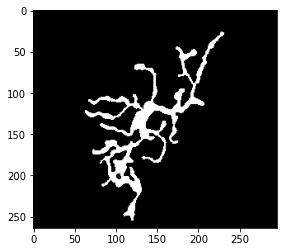

In [6]:
image, label = dp[0]
plt.imshow(image, cmap='gray')
print('Label (numeric):', label)
print('Label (textual):', class_list[label])

Label (numeric): 0
Label (textual): brainstem


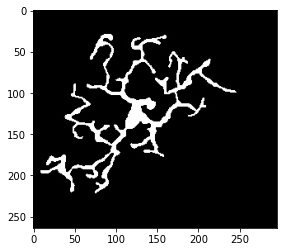

In [25]:
image, label = dp[1]
plt.imshow(image, cmap='gray')
print('Label (numeric):', label)
print('Label (textual):', class_list[label])

Label (numeric): 0
Label (textual): brainstem


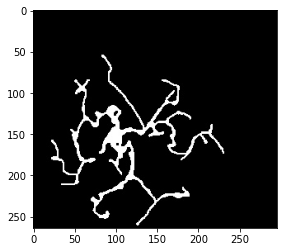

In [26]:
image, label = dp[2]
plt.imshow(image, cmap='gray')
print('Label (numeric):', label)
print('Label (textual):', class_list[label])

In [7]:
fraclac = pd.read_csv('fraclac_final_results.csv')

In [8]:
fraclac.head()

,Unnamed: 0,animal,microglia,fractal_dimension,lacunarity,outline_mean_fg,density,span_ratio_major_minor,convex_hull_area,convex_hull_perimeter,...,mean_radius,max_span_across_convex_hull,max_min_radii,shape_mean_fg,1_pixel_side_micron,1_pixel_area_micron_sq,cell_area,cell_perimeter,roughness,cell_circularity
0,0,WT1_CN284_1TDTE,WT1_CN284_1TDTE_VEH_Fatia_1_Brainstem_Imagem_1...,1.4037,0.3966,1917,0.0829,1.4649,23123,597.1008,...,99.2481,213.6212,1.6396,3272,0.608108,0.369795,1209.970782,1165.743243,1.952339,0.011189
1,1,WT1_CN284_1TDTE,WT1_CN284_1TDTE_VEH_Fatia_1_Brainstem_Imagem_1...,1.4200,0.3357,1337,0.1041,1.9033,12838,458.5077,...,81.2392,178.7568,2.1538,2319,0.608108,0.369795,857.555698,813.040541,1.773232,0.016302
2,2,WT1_CN284_1TDTE,WT1_CN284_1TDTE_VEH_Fatia_1_Brainstem_Imagem_2...,1.4618,0.3402,1105,0.1100,1.5047,10049,386.6103,...,63.7786,147.2583,1.7446,2142,0.608108,0.369795,792.101899,671.959459,1.738080,0.022045
3,3,WT1_CN284_1TDTE,WT1_CN284_1TDTE_VEH_Fatia_1_Brainstem_Imagem_2...,1.3559,0.3978,1813,0.0805,1.4708,22508,597.0781,...,103.9075,230.5862,1.8113,2585,0.608108,0.369795,955.921293,1102.500000,1.846492,0.009883
4,4,WT1_CN284_1TDTE,WT1_CN284_1TDTE_VEH_Fatia_1_Brainstem_Imagem_2...,1.4300,0.3743,1683,0.0968,1.6200,17389,517.5315,...,89.8312,191.4419,1.4358,2567,0.608108,0.369795,949.264974,1023.445946,1.977553,0.011389


In [9]:
fraclac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   210 non-null    int64  
 1   animal                       210 non-null    object 
 2   microglia                    210 non-null    object 
 3   fractal_dimension            210 non-null    float64
 4   lacunarity                   210 non-null    float64
 5   outline_mean_fg              210 non-null    int64  
 6   density                      210 non-null    float64
 7   span_ratio_major_minor       210 non-null    float64
 8   convex_hull_area             210 non-null    int64  
 9   convex_hull_perimeter        210 non-null    float64
 10  convex_hull_circularity      210 non-null    float64
 11  diameter_bounding_circle     210 non-null    float64
 12  mean_radius                  210 non-null    float64
 13  max_span_across_conv

In [10]:
fraclac.describe()

,Unnamed: 0,fractal_dimension,lacunarity,outline_mean_fg,density,span_ratio_major_minor,convex_hull_area,convex_hull_perimeter,convex_hull_circularity,diameter_bounding_circle,mean_radius,max_span_across_convex_hull,max_min_radii,shape_mean_fg,1_pixel_side_micron,1_pixel_area_micron_sq,cell_area,cell_perimeter,roughness,cell_circularity
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02,2.100000e+02,210.000000,210.000000,210.000000,210.000000
mean,104.500000,1.448816,0.360126,2130.380952,0.095576,1.581950,22670.776190,590.211901,0.803983,228.093266,99.677161,226.210711,1.828611,3720.485714,6.081081e-01,3.697955e-01,1375.818768,1295.501931,2.177516,0.010939
std,60.765944,0.052119,0.036899,521.223825,0.012567,0.406744,6228.511083,75.129568,0.070780,30.622418,12.916786,30.848675,0.414053,983.028799,1.558026e-15,1.001588e-15,363.519598,316.960434,0.354060,0.003010
min,0.000000,1.316300,0.264100,1102.000000,0.060900,1.021500,10049.000000,383.606500,0.518800,131.191000,63.140400,130.096100,1.161900,1816.000000,6.081081e-01,3.697955e-01,671.548576,670.135135,1.263767,0.005022
25%,52.250000,1.414575,0.337150,1773.750000,0.086825,1.294950,18133.500000,536.295425,0.763900,207.194375,90.037350,205.375850,1.546200,3028.000000,6.081081e-01,3.697955e-01,1119.740687,1078.631757,1.929412,0.008755
50%,104.500000,1.444050,0.359700,2079.500000,0.094400,1.500000,21674.500000,585.100000,0.816550,226.080650,98.914800,224.813200,1.715800,3640.000000,6.081081e-01,3.697955e-01,1346.055515,1264.560811,2.157059,0.010680
75%,156.750000,1.485300,0.381225,2460.500000,0.104100,1.756400,26081.000000,641.668275,0.855125,250.159925,108.895225,249.206700,2.027725,4274.750000,6.081081e-01,3.697955e-01,1580.783190,1496.250000,2.390743,0.012270
max,209.000000,1.601800,0.477800,4049.000000,0.134800,3.281900,39256.000000,769.573500,0.938400,300.655900,133.509700,300.655900,3.557800,7115.000000,6.081081e-01,3.697955e-01,2631.094777,2462.229730,3.223318,0.022342


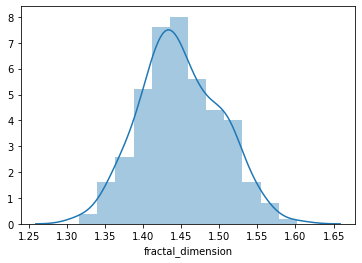

In [11]:
sns.distplot(fraclac["fractal_dimension"])

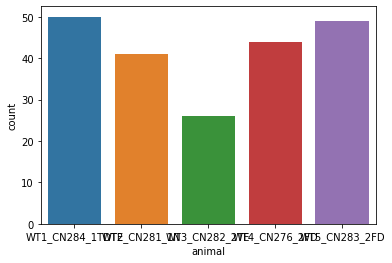

In [12]:
sns.countplot(x='animal', data=fraclac)

In [13]:
fraclac['animal'].value_counts()

WT1_CN284_1TDTE    50
WT5_CN283_2FD      49
WT4_CN276_2FD      44
WT2_CN281_1N       41
WT3_CN282_2TE      26
Name: animal, dtype: int64

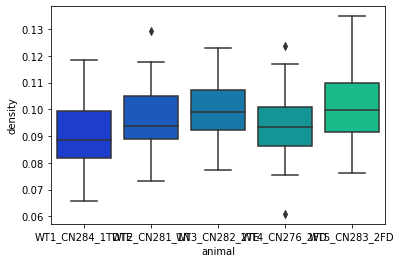

In [14]:
sns.boxplot(x='animal',y='density',data=fraclac,palette='winter')

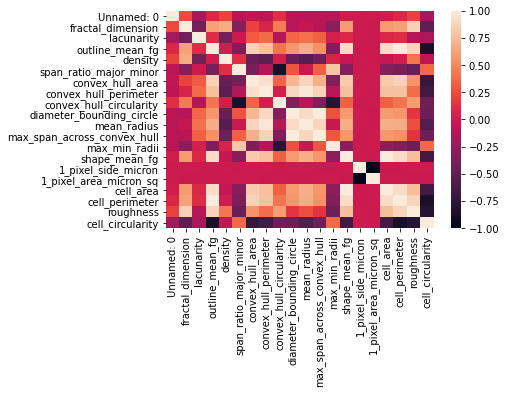

In [15]:
sns.heatmap(fraclac.corr())

In [16]:
fraclac['type'] = fraclac['microglia'].str.split('_').str[-1]

In [17]:
fraclac['Mnumber'] = fraclac['type'].str[-1]
fraclac['Mnumber']

0      1
1      2
2      1
3      2
4      3
      ..
205    3
206    1
207    2
208    3
209    4
Name: Mnumber, Length: 210, dtype: object

In [18]:
fraclac['Mname'] = fraclac['type'].str[:-1]
fraclac['Mname'] = [x.replace(x, 'Microglia') for x in fraclac['Mname']]


In [19]:
fraclac['type'] = fraclac['Mname'] + fraclac['Mnumber']

In [20]:
fraclac['type'].value_counts()

Microglia1    52
Microglia2    49
Microglia3    44
Microglia4    37
Microglia5    20
Microglia6     8
Name: type, dtype: int64

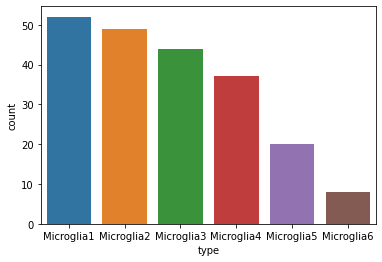

In [21]:
sns.countplot(x='type',data=fraclac)

In [22]:
skeleton = pd.read_csv('skeleton_final_results.csv')

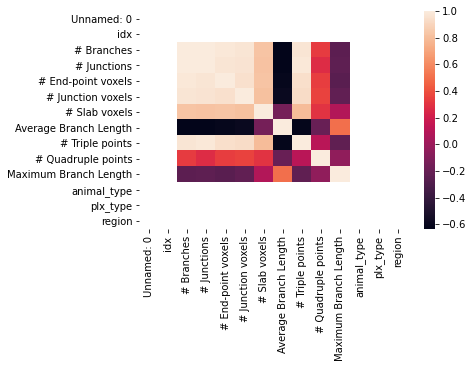

In [23]:
sns.heatmap(skeleton.corr())

In [34]:
fraclac['animal'].unique()



array(['WT1_CN284_1TDTE', 'WT2_CN281_1N', 'WT3_CN282_2TE',
       'WT4_CN276_2FD', 'WT5_CN283_2FD'], dtype=object)

In [32]:
rat1 = fraclac[fraclac['animal'] == 'WT1_CN284_1TDTE']
rat1['type'].unique()

array(['Microglia1', 'Microglia2', 'Microglia3', 'Microglia4',
       'Microglia5', 'Microglia6'], dtype=object)

In [35]:
rat2 = fraclac[fraclac['animal'] == 'WT2_CN281_1N']
rat2['type'].unique()

array(['Microglia1', 'Microglia2', 'Microglia3', 'Microglia4',
       'Microglia5'], dtype=object)

In [37]:
rat3 = fraclac[fraclac['animal'] == 'WT3_CN282_2TE']
rat3['type'].unique()

array(['Microglia1', 'Microglia2', 'Microglia3', 'Microglia4',
       'Microglia5', 'Microglia6'], dtype=object)

In [38]:
rat4 = fraclac[fraclac['animal'] == 'WT4_CN276_2FD']
rat4['type'].unique()

array(['Microglia1', 'Microglia2', 'Microglia3', 'Microglia4',
       'Microglia5', 'Microglia6'], dtype=object)

In [39]:
rat5 = fraclac[fraclac['animal'] == 'WT5_CN283_2FD']
rat5['type'].unique()

array(['Microglia1', 'Microglia2', 'Microglia3', 'Microglia4',
       'Microglia5', 'Microglia6'], dtype=object)

# Analyzing Dataset - VAE

In [ ]:
import numpy as np
#Import images with 64x64 resolution
img_64 = np.load('Microglia_Data/Images_VAE/64x64/array_of_images_64_64_20210316.npy')
label_64= np.load('Microglia_Data/Images_VAE/64x64/array_of_labels_64_64_20210316.npy')
#Import images with 256x256 resolution
img_256 = np.load('Microglia_Data/Images_VAE/256x256/array_of_images_256_256_20210402_FULL.npy')
label_256 = np.load('Microglia_Data/Images_VAE/256x256/array_of_labels_256_256_20210402_FULL.npy')

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def analyze_data(img_list, img_labels, title):
    print(50*'*')
    print("Images (X) shape:", img_list.shape)
    print("Images (y) shape:", img_labels.shape)
    visualize_data(img_list, img_labels, title)
    print(50*'*')

#Matplotlib it
def visualize_data(img_list, img_labels, title):
    #a set of 9 figures
    fig = plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tf.squeeze(img_list[i]))

In [ ]:
#Analyzing 64x64 images data
analyze_data(img_64, label_64, 'teste')

In [ ]:
#Analyzing 256x256 images data
analyze_data(img_256, label_256, 'teste')